## Importation packages et données

In [1]:
#Importation du package RDKIT
conda install -c rdkit rdkit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/aminatandiaye/opt/anaconda3

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libboost-1.67.0            |       hebc422b_4        12.7 MB
    py-boost-1.67.0            |   py37h6440ff4_4         286 KB
    rdkit-2020.03.2.0          |   py37h65625ec_1        23.2 MB  rdkit
    ------------------------------------------------------------
                                           Total:        36.1 MB



In [159]:
#Importation librairies usuelles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importation rdkit
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

#Importation sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#Importation données
data_train=pd.read_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/train_set_data.csv')
data_test=pd.read_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/test_set_data.csv')

In [160]:
list(data_train["Activity"]).count(0)



213

Notre trainset est composé de 300 molécules tandis que nous devons prédire l'activité de 8368 molécules

## Question préliminaire
Construire une description vectorielle des molécules en utilisant le
fingerprint RDKIT « MACCSkeys »

In [5]:
#Construction matrices de description vectorielle des molécules en utilisant le fingerprint 'MACCSkeys'
pd_fps_train=pd.DataFrame([list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()) for x in data_train['SMILES']])
pd_fps_test=pd.DataFrame([list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()) for x in data_test['SMILES']])

In [6]:
pd_fps_train

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
296,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
297,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
298,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [7]:
fps_train=pd_fps_train.astype(np.float64)
fps_train=fps_train.to_numpy()

## Statistiques Descriptives

In [8]:
len(fps_train[1][:])


167

In [9]:
# Nous calculons le vecteur moyen de la matrice de features
x_mean=fps_train.astype(np.float64).mean(axis=0)

In [10]:
len(x_mean)

167

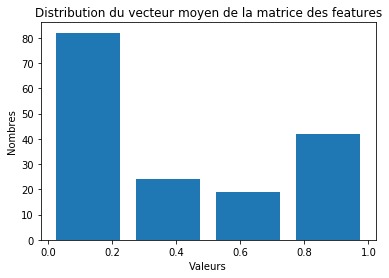

In [11]:
plt.hist(x_mean,bins=[0,0.25,0.5,0.75,1],rwidth=0.8) # discrétisation utililisée ['[0,0.25[','[0.25,0.5[','[0.5,0.75[','[0.75,1]']
plt.xlabel('Valeurs')
plt.ylabel('Nombres')
plt.title("Distribution du vecteur moyen de la matrice des features")
plt.show()

In [13]:
fps_train_center=np.zeros((300,167))
for i in range(len(fps_train)):
    fps_train_center[i,:]=fps_train[i,:]-x_mean

In [14]:
pd.DataFrame(fps_train_center)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,-0.76,0.003333,-0.836667,-0.78,0.0,0.0,0.0,0.013333,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,-0.76,0.003333,0.163333,-0.78,0.0,0.0,0.0,0.013333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,-0.78,0.0,0.0,0.0,0.013333,0.0,0.0
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003333,0.0,...,0.24,0.003333,0.163333,0.22,0.0,0.0,0.0,0.013333,0.0,0.0


Nous appliquons une analyse en composantes principales

In [15]:
model_PCA=PCA()
fps_train_pca=model_PCA.fit_transform(fps_train_center)

In [16]:
var_expl=model_PCA.explained_variance_ratio_.cumsum()

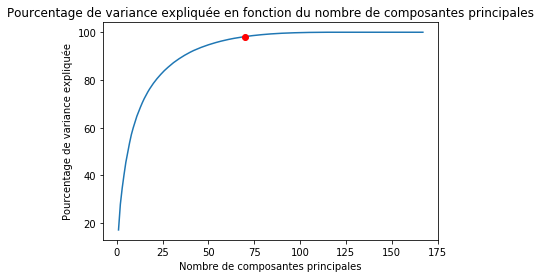

In [17]:
plt.plot(range(1,168),var_expl*100)
plt.xlabel('Nombre de composantes principales')
plt.plot(70,var_expl[69]*100, marker="o", color="red")
plt.ylabel('Pourcentage de variance expliquée')
plt.title("Pourcentage de variance expliquée en fonction du nombre de composantes principales")
plt.show()

Nuage de points de la matrice de features projetée dans le plan de ses composantes principales les plus explicatives.

Text(0, 0.5, 'Seconde composante principale')

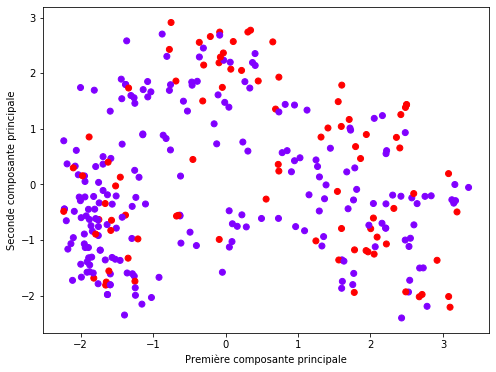

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(fps_train_pca[:,0],fps_train_pca[:,1],c=data_train['Activity'],cmap='rainbow')
plt.xlabel('Première composante principale')
plt.ylabel('Seconde composante principale')

## Sélection de modèle

Nous allons optimiser et tester 5 modèles: 
* la régression logistique
* la méthode Naive Bayésienne
* le random forest
* le voting classifier
* K-plus proches voisins


Nous optimiserons les paramètres des différents modèles avec la fonction GridSearchCV puis nous optimiserons les paramètres radius et nbits du Morgan fingerprint en testant les 24 configurations possibles et en choissant la meilleure.

Nous utiliserons comme métrique l'accuracy, le jeu de données n'étant pas extrêmement déséquilibré (70 % de 0 et 30% de 1),cette métrique est adaptée. Nous prendrons quand même en considération deux autres métriques (l'auc_roc et le F1-score) qui sont plus adaptées aux données déséquilibrées


In [327]:
# Paramètres de Morgan Fingerprint
radius_vec=range(1,7)
nBits_vec=[512,1024,2048,4096]
rad=radius_vec[3]#meilleur paramètre: 3
nbits=nBits_vec[1]#meilleur paramètre: 1


In [328]:
#On initialise le tableau des résultats 

resultats = pd.DataFrame(columns = ['Accuracy train','Accuracy test', 
                                 'ROC AUC Score','F1-Score'], 
                      index = ['Voting Classifier', 
                               'Random Forest','KNeighbors', 
                               'Régression logistique','Naive Bayesien'])


In [329]:
data_train=pd.read_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/train_set_data.csv')

#Construction matrices de description vectorielle des molécules en utilisant le fingerprint 'Morgan'
Morganfps=pd.DataFrame([list(GetMorganFingerprintAsBitVect(mol=Chem.MolFromSmiles(x),radius=rad,nBits=nbits).ToBitString()) for x in data_train['SMILES']])
data=Morganfps.astype(np.float64)
data=data.to_numpy()
y=data_train['Activity']
#Séparation de l'ensemble d'entrainement et de l'ensemble de validation
X_train, X_val,y_train, y_val=train_test_split(data, y, train_size=0.8,test_size=0.2, random_state=2022)


### Régression Logistique

In [342]:
#On détermine les paramètres optimaux avec la fonction Grid SearchCV
param_grid_lr = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C':np.logspace(-4,4,20), 'max_iter':[1000]}
lrModel_grid=GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, verbose=1, cv=10,n_jobs=1)
lrModel_grid.fit(X_train,y_train)
LR_tuned=lrModel_grid.best_estimator_ #Le modèle avec les meilleures paramètres

    

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Converg

/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklea

/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklea

/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/aminatandiaye/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  5.8min finished


In [346]:
#Entrainement du modèle
LR=LR_tuned
LR.fit(X_train,y_train)
y_pred_lr = LR.predict(X_val)
y_prob_lr=LR.predict_proba(X_val)[::,1] # On calcule notre vecteur de proba prédite pour la fonction roc_curve
d_lr = accuracy_score(y_train,LR.predict(X_train)) #on calcule notre accuracy train
a_lr = accuracy_score(y_val, y_pred_lr)  #on calcule notre accuracy
b_lr = roc_auc_score(y_val, y_prob_lr)#on calcule notre roc auc 
c_lr = f1_score(y_val, y_pred_lr)#on calcule notre f1-score
resultats.loc['Régression logistique'] = [d_lr, a_lr, b_lr,c_lr] #on enregistre notre accuracy et notre ROC AUC pour pouvoir les comparer ensuite

### Naive Bayésien

In [332]:
#On détermine les paramètres optimaux avec la fonction Grid SearchCV
param_grid_nb={ 'var_smoothing': np.logspace(0,-9,num=100)}
nbModel_grid=GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10,n_jobs=1)
nbModel_grid.fit(X_train,y_train)
nb_tuned=nbModel_grid.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


In [333]:
nb=nb_tuned
nb.fit(X_train,y_train)
y_pred_nb = nb.predict(X_val)
y_prob_nb=nb.predict_proba(X_val)[::,1] # On calcule notre vecteur de proba prédite pour la fonction roc_curve
d_nb = accuracy_score(y_train,nb.predict(X_train)) #on calcule notre accuracy train
a_nb = accuracy_score(y_val, y_pred_nb)  #on calcule notre accuracy
b_nb = roc_auc_score(y_val, y_prob_nb)#on calcule notre roc auc 
c_nb = f1_score(y_val, y_pred_nb)#on calcule notre f1-score
resultats.loc['Naive Bayesien'] = [d_nb, a_nb, b_nb,c_nb] #on enregistre notre accuracy et notre ROC AUC pour pouvoir les comparer ensuite

### K-plus proches voisins

In [334]:

param_grid_km = {'n_neighbors':list(range(1,15))}
kmModel_grid=GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_km, verbose=1, cv=10,n_jobs=1)
kmModel_grid.fit(X_train,y_train)
km_tuned=rfModel_grid.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.8s finished


In [335]:

km=km_tuned
km.fit(X_train,y_train)
y_pred_km = km.predict(X_val)
y_prob_km=rf.predict_proba(X_val)[::,1] # On calcule notre vecteur de proba prédite pour la fonction roc_curve
d_km = accuracy_score(y_train,km.predict(X_train)) #on calcule notre accuracy train
a_km = accuracy_score(y_val, y_pred_km)  #on calcule notre accuracy
b_km = roc_auc_score(y_val, y_prob_km)#on calcule notre roc auc 
c_km = f1_score(y_val, y_pred_km)#on calcule notre f1-score
resultats.loc['KNeighbors'] = [d_km, a_km, b_km,c_km] #on enregistre notre accuracy et notre ROC AUC pour pouvoir les comparer ensuite

### Random Forest

In [336]:
#On détermine les paramètres optimaux avec la fonction Grid SearchCV
param_grid_rf = {'n_estimators':list(range(10,101,10)), 'max_features':list(range(6,32,5))}
rfModel_grid=GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, verbose=1, cv=10,n_jobs=1)
rfModel_grid.fit(X_train,y_train)
rf_tuned=rfModel_grid.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   51.0s finished


In [337]:
rf=rf_tuned
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_val)
y_prob_rf=rf.predict_proba(X_val)[::,1] # On calcule notre vecteur de proba prédite pour la fonction roc_curve
d_rf = accuracy_score(y_train,rf.predict(X_train)) #on calcule notre accuracy train
a_rf = accuracy_score(y_val, y_pred_rf)  #on calcule notre accuracy
b_rf = roc_auc_score(y_val, y_prob_rf)#on calcule notre roc auc 
c_rf = f1_score(y_val, y_pred_rf)#on calcule notre f1-score
resultats.loc['Random Forest'] = [d_rf, a_rf, b_rf,c_rf] #on enregistre notre accuracy et notre ROC AUC pour pouvoir les comparer ensuite

### Voting Classifier

In [344]:
#On récupère les modèles 
clf1 = LR_tuned
clf2 = rf_tuned
clf3 = nb_tuned
clf4 = km_tuned
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('nb', clf3),('km', clf4)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)

y_pred_vc = eclf1.predict(X_val)

y_prob_vc = eclf1.predict_proba(X_val)[::,1] # On calcule notre vecteur de proba prédite pour la fonction roc_curve
d_vc = accuracy_score(y_train,eclf1.predict(X_train)) #on calcule notre accuracy train
a_vc = accuracy_score(y_val, y_pred_vc)  #on calcule notre accuracy test
b_vc = roc_auc_score(y_val, y_prob_vc)#on calcule notre roc auc 
c_vc = f1_score(y_val, y_pred_vc)#on calcule notre f1-score
resultats.loc['Voting Classifier'] = [d_vc, a_vc,b_vc,c_vc] #on enregistre notre accuracy et notre ROC AUC pour pouvoir les comparer ensuite

In [347]:
#On affiche le tableau de résultats
print(resultats)

                      Accuracy train Accuracy test ROC AUC Score  F1-Score
Voting Classifier           0.991667           0.8      0.903723       0.6
Random Forest               0.995833      0.816667      0.821566  0.592593
KNeighbors                         1           0.8      0.905006  0.571429
Régression logistique       0.991667          0.85      0.887035  0.709677
Naive Bayesien              0.945833      0.783333      0.807445  0.551724


Le meilleure modèle est le modèle de régression logistique

## Prediction avec le modèle de régression logistique

In [348]:
data_test=pd.read_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/test_set_data.csv')
#Construction matrices de description vectorielle des molécules en utilisant le fingerprint 'Morgan'
Morganfps_test=pd.DataFrame([list(GetMorganFingerprintAsBitVect(mol=Chem.MolFromSmiles(x),radius=rad,nBits=nbits).ToBitString()) for x in data_test['SMILES']])
data_test=Morganfps_test.astype(np.float64)
data_test=data_test.to_numpy()


In [349]:
activity_pred=LR.predict(data_test)


In [350]:
data_test=pd.read_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/test_set_data.csv')
data_test['Activity']=activity_pred


In [351]:
data_test.to_csv('/Users/aminatandiaye/Downloads/Notebook IKTOS/predictions/test_set_data.csv')